# 12-gdal-preprocessing
> Preprocessing our data in GDAL and outputting CSVs for ML models

See notebook 11 for imports and installs.

In [1]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [131]:
import os

In [132]:
# Replace with the path to your data file. Use the file with the .tif extension
file_2001 = './data/VDS Team Data Share/CONUS2001_ClipAOI.tif'
file_2004 = './data/VDS Team Data Share/CONUS2004_ClipAOI.tif'
file_2006 = './data/VDS Team Data Share/CONUS2006_ClipAOI.tif'
file_2008 = './data/VDS Team Data Share/CONUS2008_ClipAOI.tif'
file_2011 = './data/VDS Team Data Share/CONUS2011_ClipAOI.tif'
file_2013 = './data/VDS Team Data Share/CONUS2013_ClipAOI.tif'
file_2016 = './data/VDS Team Data Share/CONUS2016_ClipAOI.tif'
file_2019 = './data/VDS Team Data Share/CONUS2019_ClipAOI.tif'

### Preprocess function

Change the output file path to a folder where you want the files to go.

Paramater Note:
srcWin = [xoff, yoff, xsize, ysize]

Outputs:
- ds_year_t.tif (a 1000 x 1000 subset of the tif file for that year)
- ds_year_tw.tif (a resampled subset of the above tif file, resolution defaults to 100)
- ds_year_tw.xyz (an xyz file with x=xcoord, y=ycoord, and z = raster value)
- ds_year_tw.csv (final csv contains coordinates of each pixel and the value)

In [152]:
def preprocess(file, year, folder, resolution=100, xoff=8000, yoff=8000, size=1000):
    tag = str(resolution) + 'r_' + str(xoff) + 'x_' + str(yoff) +'y'
    output = folder + '/ds_' + str(year) + '_' + tag
    ds = gdal.Open(file)
    ds_t = gdal.Translate(output + '_t.tif', ds, srcWin = [xoff, yoff, size, size])
    ds_tw = gdal.Warp(output + '_tw.tif', ds_t, xRes = resolution, yRes = resolution)
    xyz = gdal.Translate(output + '_tw.xyz', ds_tw)
    df = pd.read_csv(output + '_tw.xyz', sep=" ", header = None)
    df.columns = ['x','y',str(year)]
    df.to_csv(output + '_tw.csv')
    return df

### Creating the Master CSV File

In [153]:
# Opens and plots a raster image (can't be too big though)
def visualize(path):
    ds = gdal.Open(path)
    band = ds.GetRasterBand(1)
    array = band.ReadAsArray()
    plt.figure(figsize=(10, 10))
    plt.imshow(array)
    plt.colorbar()

In [154]:
# lists of file names and years for below function
files = [file_2001, file_2004, file_2006, file_2008, file_2011, file_2013, file_2016, file_2019]
years = [2001,2004,2006,2008,2011,2013,2016,2019]

### create_stats

The goal of this function is to convert a raster image into csv data which has the coordinates of pixels along with their values. The problem I was running into was that converting it all at once created a gargantuan file. So this function allows you to specify a subset of the raster image and to compress the result to a different resolution.

Parameters:
- files: list of files to open, specified earlier
- resolution: defaults to 30 meters, make bigger to make csvs smaller and more compressed (data loss)
- xoff / yoff : the coordinate in which to grab the window
- size : the size of the window, or the subset in which you are viewing.

Output:
- Master CSV. Contains points and raster values for each year for each of the coordinates specified in the window. The coordinates change based on the resolution (steps of 100, for example) (Ex file name: stats_100r_6000x_5000y.csv)
- Automatically generates a folder in which to store preliminary data (Ex folder name: files_100r_6000x_5000y). The data in here is created for each call of create_stats and contains the csv for each of the different years as well as all the tif files before and after they are warped to different resolutions. Also contained is the transitory xyz file that is used to convert to csv later.

In [150]:
def create_stats(files, resolution=100, xoff=8000, yoff=8000, size=1000):
    tag = str(resolution) + 'r_' + str(xoff) + 'x_' + str(yoff) +'y'
    folder = './data/files_' + tag
    if not os.path.exists(folder):
        os.makedirs(folder)
    df_01 = preprocess(files[0], years[0], folder, resolution=resolution, xoff=xoff, yoff=yoff, size=size)
    df_01['id'] = df_01.index
    frames = [df_01['id'], df_01['x'], df_01['y']]
    for i in range(1,8):
        df = preprocess(files[i], years[i], folder, resolution=resolution, xoff=xoff, yoff=yoff, size=size)
        frames.append(df[str(years[i])])
    result = pd.concat(frames, axis=1)
    output = './data/stats_' + tag + '.csv'
    result.to_csv(output)
    visualize(folder + '/ds_2001_' + tag + '_tw.tif')
    return result

In [151]:
#Columns: 35165
#Rows: 17975

,id,x,y,2004,2006,2008,2011,2013,2016,2019
0,0,544779.250009,1.587498e+06,41,41,41,41,41,41,41
1,1,544879.250009,1.587498e+06,41,41,41,41,41,41,41
2,2,544979.250009,1.587498e+06,41,41,41,41,41,41,41
3,3,545079.250009,1.587498e+06,41,43,41,43,41,41,41
4,4,545179.250009,1.587498e+06,41,41,41,41,41,41,41
...,...,...,...,...,...,...,...,...,...,...
89995,89995,574279.250009,1.557598e+06,82,82,82,82,82,82,82
89996,89996,574379.250009,1.557598e+06,82,82,82,82,82,82,82
89997,89997,574479.250009,1.557598e+06,82,82,82,82,82,82,82
89998,89998,574579.250009,1.557598e+06,82,82,82,82,82,82,82


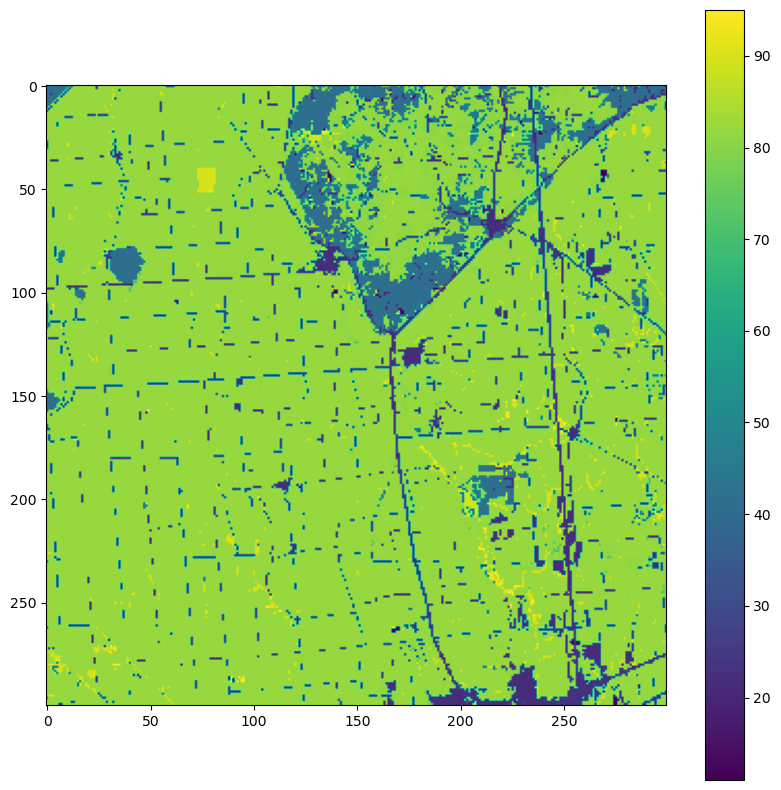

In [158]:
create_stats(files, xoff=6000, yoff=5000)

### Previous Testing

This is where I was creating the csv function.

In [59]:
df_2001 = preprocess(file_2001, 2001)
df_2004 = preprocess(file_2004, 2004)
df_2006 = preprocess(file_2006, 2006)
df_2008 = preprocess(file_2008, 2008)
df_2011 = preprocess(file_2011, 2011)
df_2013 = preprocess(file_2013, 2013)
df_2016 = preprocess(file_2016, 2016)
df_2019 = preprocess(file_2019, 2019)

In [60]:
df_01 = pd.read_csv('./data/preprocess/ds_2001_tw.csv')
df_04 = pd.read_csv('./data/preprocess/ds_2004_tw.csv')
df_06 = pd.read_csv('./data/preprocess/ds_2006_tw.csv')
df_08 = pd.read_csv('./data/preprocess/ds_2008_tw.csv')
df_11 = pd.read_csv('./data/preprocess/ds_2011_tw.csv')
df_13 = pd.read_csv('./data/preprocess/ds_2013_tw.csv')
df_16 = pd.read_csv('./data/preprocess/ds_2016_tw.csv')
df_19 = pd.read_csv('./data/preprocess/ds_2019_tw.csv')

In [74]:
df_01

,id,X,Y,2001
0,0,604778.743636,1.497500e+06,21
1,1,604878.743636,1.497500e+06,21
2,2,604978.743636,1.497500e+06,82
3,3,605078.743636,1.497500e+06,82
4,4,605178.743636,1.497500e+06,82
...,...,...,...,...
89995,89995,634278.743636,1.467600e+06,42
89996,89996,634378.743636,1.467600e+06,41
89997,89997,634478.743636,1.467600e+06,82
89998,89998,634578.743636,1.467600e+06,21


In [62]:
df_01 = df_01.rename(columns={"Unnamed: 0": "id", "x": "X", "y": "Y", "value": "value"})

In [63]:
frames = [df_01['id'], df_01['X'], df_01['Y'], df_01['2001'], df_04['2004'], df_06['2006'], df_08['2008'], df_11['2011'], df_13['2013'], df_16['2016'], df_19['2019']]
result = pd.concat(frames, axis=1)

In [64]:
result

,id,X,Y,2001,2004,2006,2008,2011,2013,2016,2019
0,0,604778.743636,1.497500e+06,21,82,21,82,82,21,82,82
1,1,604878.743636,1.497500e+06,21,81,21,81,81,21,81,81
2,2,604978.743636,1.497500e+06,82,81,82,81,81,82,81,81
3,3,605078.743636,1.497500e+06,82,81,82,81,81,82,81,81
4,4,605178.743636,1.497500e+06,82,81,82,81,81,82,81,81
...,...,...,...,...,...,...,...,...,...,...,...
89995,89995,634278.743636,1.467600e+06,42,41,42,41,41,42,41,41
89996,89996,634378.743636,1.467600e+06,41,90,41,90,90,41,90,90
89997,89997,634478.743636,1.467600e+06,82,82,82,82,82,82,82,82
89998,89998,634578.743636,1.467600e+06,21,82,21,82,82,21,82,82


In [66]:
result.to_csv('./data/stats.csv')

## Previous Testing

This is where I was messing to create the preprocess function.

In [4]:
# Convert to GDAL dataset
ds_2001 = gdal.Open(file_2001)
ds_2004 = gdal.Open(file_2004)
ds_2006 = gdal.Open(file_2006)
ds_2008 = gdal.Open(file_2008)
ds_2011 = gdal.Open(file_2011)
ds_2013 = gdal.Open(file_2013)
ds_2016 = gdal.Open(file_2016)
ds_2019 = gdal.Open(file_2019)

In [7]:
ds_2001_t = gdal.Translate('./data/subset_tif/ds_2001_t.tif', ds_2001, srcWin = [8000, 8000, 1000, 1000])
ds_2004_t = gdal.Translate('./data/subset_tif/ds_2004_t.tif', ds_2004, srcWin = [8000, 8000, 1000, 1000])
ds_2006_t = gdal.Translate('./data/subset_tif/ds_2006_t.tif', ds_2006, srcWin = [8000, 8000, 1000, 1000])
ds_2008_t = gdal.Translate('./data/subset_tif/ds_2008_t.tif', ds_2008, srcWin = [8000, 8000, 1000, 1000])
ds_2011_t = gdal.Translate('./data/subset_tif/ds_2011_t.tif', ds_2011, srcWin = [8000, 8000, 1000, 1000])
ds_2013_t = gdal.Translate('./data/subset_tif/ds_2013_t.tif', ds_2013, srcWin = [8000, 8000, 1000, 1000])
ds_2016_t = gdal.Translate('./data/subset_tif/ds_2016_t.tif', ds_2016, srcWin = [8000, 8000, 1000, 1000])
ds_2019_t = gdal.Translate('./data/subset_tif/ds_2019_t.tif', ds_2019, srcWin = [8000, 8000, 1000, 1000])

In [8]:
# Sample Visualization
band_2001_t = ds_2001_t.GetRasterBand(1)
array_2001_t = band_2001_t.ReadAsArray()

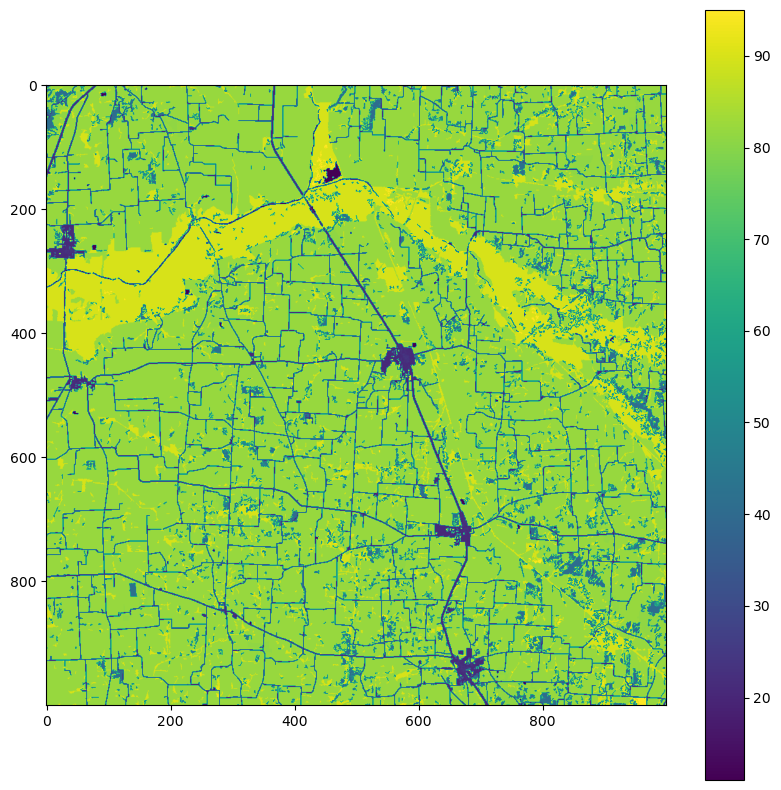

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(array_2001_t)
plt.colorbar()

In [17]:
# Can set different sampling methods
# Ex: resampleAlg = "bilinear"
SIZE = 100
ds_2001_tw = gdal.Warp("./data/subset_tif/ds_2001_t_scaled.tif", ds_2001_t, xRes = SIZE, yRes = SIZE)
ds_2004_tw = gdal.Warp("./data/subset_tif/ds_2004_t_scaled.tif", ds_2004_t, xRes = SIZE, yRes = SIZE)
ds_2006_tw = gdal.Warp("./data/subset_tif/ds_2006_t_scaled.tif", ds_2006_t, xRes = SIZE, yRes = SIZE)
ds_2008_tw = gdal.Warp("./data/subset_tif/ds_2008_t_scaled.tif", ds_2008_t, xRes = SIZE, yRes = SIZE)
ds_2011_tw = gdal.Warp("./data/subset_tif/ds_2011_t_scaled.tif", ds_2011_t, xRes = SIZE, yRes = SIZE)
ds_2013_tw = gdal.Warp("./data/subset_tif/ds_2013_t_scaled.tif", ds_2013_t, xRes = SIZE, yRes = SIZE)
ds_2016_tw = gdal.Warp("./data/subset_tif/ds_2016_t_scaled.tif", ds_2016_t, xRes = SIZE, yRes = SIZE)
ds_2019_tw = gdal.Warp("./data/subset_tif/ds_2019_t_scaled.tif", ds_2019_t, xRes = SIZE, yRes = SIZE)

In [18]:
# Sample Visualization
band_2001_tw = ds_2001_tw.GetRasterBand(1)
array_2001_tw = band_2001_tw.ReadAsArray()

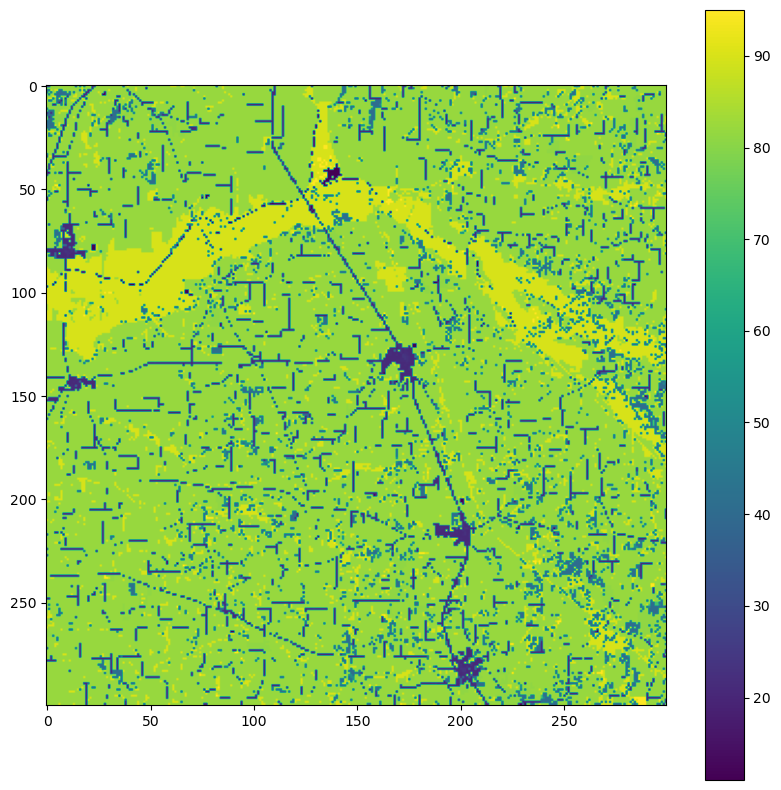

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(array_2001_tw)
plt.colorbar()